In [25]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
class FourierSeriesDataset(Dataset):
    def __init__(self, num_samples, num_points, max_terms=10):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_terms = max_terms
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.derivatives = self.generate_data()

    def generate_data(self):
        functions = []
        derivatives = []

        for _ in range(self.num_samples):
            # Generate random complex coefficients
            n_terms = np.random.randint(1, self.max_terms + 1)
            c = torch.complex(torch.randn(2*n_terms+1), torch.randn(2*n_terms+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            functions.append(y.detach().numpy())

            # Compute derivative
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(derivatives)

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        for n in range(-len(c)//2, len(c)//2 + 1):
            result += c[n + len(c)//2] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.derivatives[idx])

# Generate dataset
num_samples = 10000
num_points = 1000
# dataset = FourierSeriesDataset(num_samples, num_points)

# # Create DataLoader
# batch_size = 32
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# torch.save(dataset, 'derivative_dataset.pt')

    

## Load previously saved dataset

In [6]:
dataset = torch.load('derivative_dataset.pt')

In [50]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

In [51]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [53]:
print(len(train_dataloader))
print(len(test_dataloader))

250
62


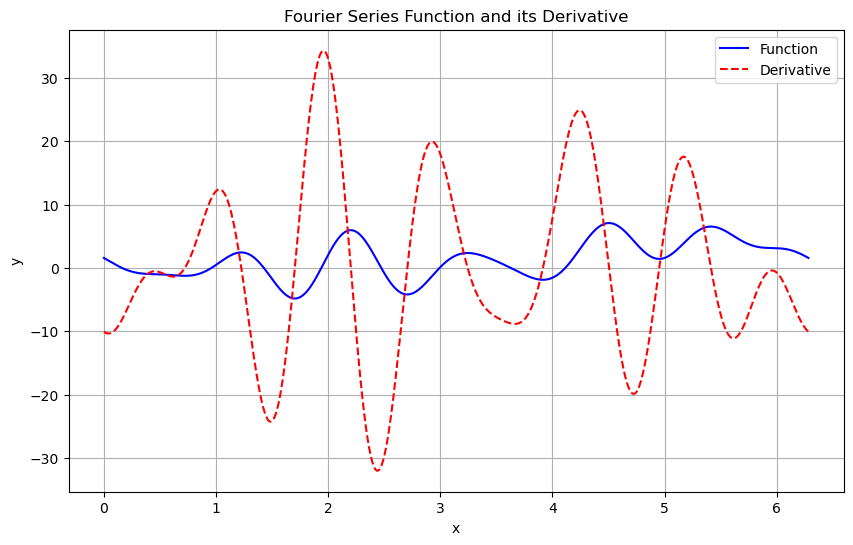

In [10]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='Derivative', color='red', linestyle='--')
    
    plt.title('Fourier Series Function and its Derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage:
# Assuming you have already created your dataset and dataloader as before
# dataset = FourierSeriesDataset(num_samples, num_points)
train_dataloader_viz = DataLoader(train_dataset, batch_size=1, shuffle=True)

plot_function_and_derivative(train_dataloader_viz)

## Model Training

Create the model

In [11]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

## Training loop

In [12]:
# Training loop
train_losses = []
test_losses = []

num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    test_loss = 0.0

    for batch_functions, batch_derivatives in train_dataloader:
        # Reshape input: [batch_size, 1, num_points]
        batch_functions = batch_functions.unsqueeze(1)
        batch_derivatives = batch_derivatives.unsqueeze(1)

        # Forward pass
        outputs = model(batch_functions)
        loss = criterion(outputs, batch_derivatives)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    model.eval()
    with torch.no_grad():
        for b_test_functions, b_test_derivatives in test_dataloader:
            b_test_functions = b_test_functions.unsqueeze(1)
            b_test_derivatives = b_test_derivatives.unsqueeze(1)

            test_outputs = model(b_test_functions)
            batch_test_loss = criterion(test_outputs, b_test_derivatives)

            test_loss += batch_test_loss.item()

    test_loss /= len(test_dataloader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


# Save the model
torch.save(model.state_dict(), 'model_weights.pth')

# To load the model later:
# model = SimpleCNN()
# model.load_state_dict(torch.load('fourier_derivative_model.pth'))
# model.eval()

print("Training finished!")

Epoch [1/300], Train Loss: 84.9189, Test Loss: 14.5304
Epoch [2/300], Train Loss: 9.1598, Test Loss: 5.7071
Epoch [3/300], Train Loss: 3.8765, Test Loss: 2.5903
Epoch [4/300], Train Loss: 2.0376, Test Loss: 1.4600
Epoch [5/300], Train Loss: 1.2582, Test Loss: 1.0952
Epoch [6/300], Train Loss: 1.1933, Test Loss: 1.1131
Epoch [7/300], Train Loss: 0.9447, Test Loss: 0.8779
Epoch [8/300], Train Loss: 0.8701, Test Loss: 1.1701
Epoch [9/300], Train Loss: 0.8184, Test Loss: 0.7512
Epoch [10/300], Train Loss: 0.8037, Test Loss: 0.6879
Epoch [11/300], Train Loss: 0.7364, Test Loss: 0.6744
Epoch [12/300], Train Loss: 0.6599, Test Loss: 0.6162
Epoch [13/300], Train Loss: 0.7439, Test Loss: 0.6363
Epoch [14/300], Train Loss: 0.7746, Test Loss: 0.5617
Epoch [15/300], Train Loss: 0.5616, Test Loss: 0.5514
Epoch [16/300], Train Loss: 0.5501, Test Loss: 0.5235
Epoch [17/300], Train Loss: 0.5335, Test Loss: 0.5094
Epoch [18/300], Train Loss: 0.6027, Test Loss: 0.5156
Epoch [19/300], Train Loss: 0.5483,

In [87]:
def plot_losses(train_losses, test_losses, xmin=None, ymax=None):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if xmin:
        plt.xlim(xmin=xmin)
        min_loss = min(min(train_losses[xmin-1:]), min(test_losses[xmin-1:]))
        max_loss = max(max(train_losses[xmin-1:]), max(test_losses[xmin-1:]))
        plt.ylim(min_loss, max_loss)
    if ymax:
        plt.ylim(ymax=ymax)
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    plt.show()

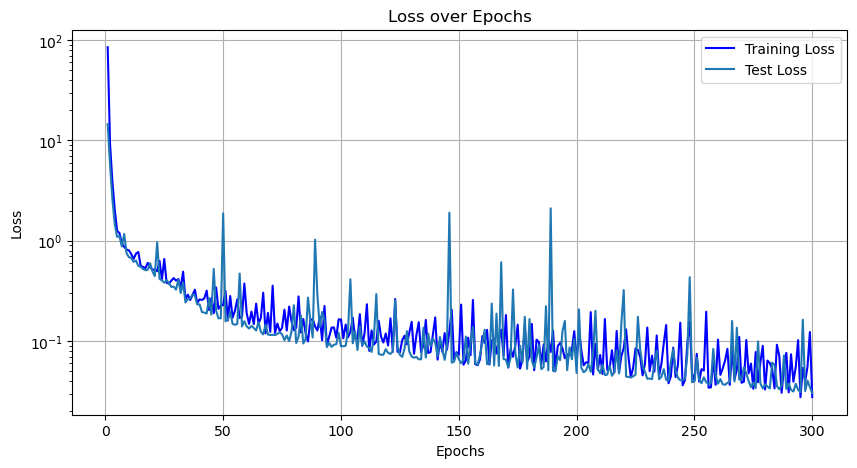

In [88]:
plot_losses(train_losses=train_losses, test_losses=test_losses)

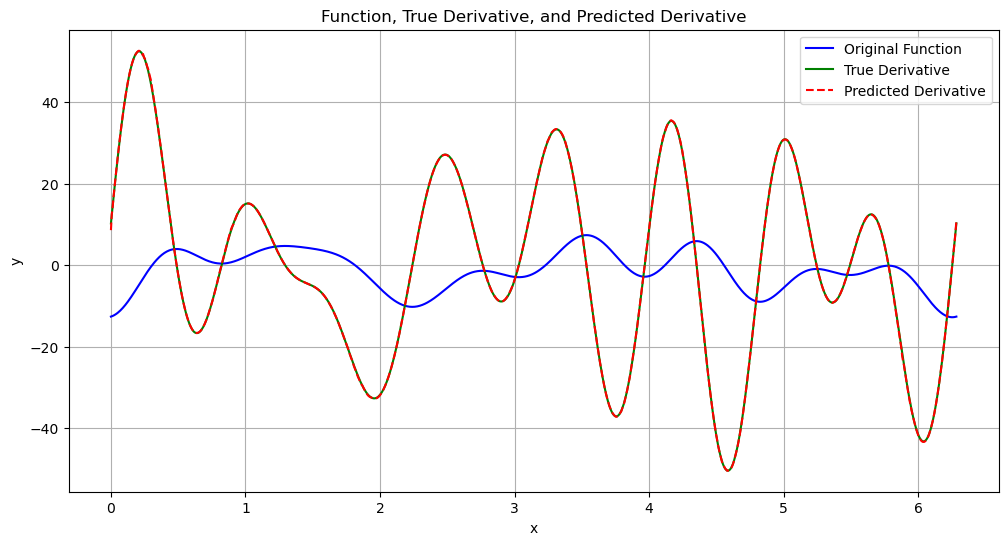

In [21]:
model.eval()  # Set the model to evaluation mode

train_dataloader_viz
# Get a random sample from the dataloader
dataiter = iter(train_dataloader_viz)
function, true_derivative = next(dataiter)

# Reshape the input for the model
function = function.unsqueeze(1)  # Add channel dimension

# Make prediction
with torch.no_grad():
    predicted_derivative = model(function)

# Convert tensors to numpy arrays for plotting
x = torch.linspace(0, 2*torch.pi, 1000).numpy()
function = function.squeeze().numpy()
true_derivative = true_derivative.squeeze().numpy()
predicted_derivative = predicted_derivative.squeeze().numpy()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(x, function, label='Original Function', color='blue')
plt.plot(x, true_derivative, label='True Derivative', color='green')
plt.plot(x, predicted_derivative, label='Predicted Derivative', color='red', linestyle='--')
plt.title('Function, True Derivative, and Predicted Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
percent_changes = [(test_losses[i] - test_losses[i - 1]) / test_losses[i - 1] * 100 for i in range(1, len(test_losses))]
num_above_5 = len([change for change in percent_changes if abs(change) > 5])



In [27]:
smallest_five = heapq.nsmallest(5, test_losses)
smallest_five

[0.03034627718466615,
 0.03118201011850957,
 0.03150756079112253,
 0.031846711619032755,
 0.03277113377338364]

In [23]:
len(test_losses)

300

In [24]:
num_above_5

233

## Multi-stage component: first correction network
This is the second network in the function, but the first "correction" network.
Uses normalized data, $\left(x_i, \frac{e_i(x_i)}{\epsilon_i}\right)$

In [ ]:
# # this function will return the new training data for the next network 
# def normalize_data(x, model_y, true_y):
#     e = true_y - model_y
    
#     epsilon = torch.sqrt(torch.mean(torch.square(e)))
#     normalized_data = e / epsilon
#     return torch.tensor((x, normalized_data))

In [28]:
def compute_normalized_residual(model, dataloader):
    model.eval()
    residuals = []
    with torch.no_grad():
        for batch_functions, batch_derivatives in dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            outputs = model(batch_functions)
            residual = outputs - batch_derivatives
            residuals.append(residual)
    
    residuals = torch.cat(residuals, dim=0)
    rms = torch.sqrt(torch.mean(residuals**2))
    normalized_residuals = residuals / rms
    return normalized_residuals, rms

In [67]:
class ResidualDataset(Dataset):
    def __init__(self, original_dataset, residuals):
        self.original_dataset = original_dataset
        self.residuals = residuals

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        _, derivative = self.original_dataset[idx]
        return derivative.unsqueeze(0), self.residuals[idx]

## Residual CNN

In [70]:
class ResidualCNN(nn.Module):
    def __init__(self):
        super(ResidualCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [71]:
model.load_state_dict(torch.load('residual_model.pth'))

# Compute normalized residuals
train_residuals, train_rms = compute_normalized_residual(model, train_dataloader)
test_residuals, test_rms = compute_normalized_residual(model, test_dataloader)

# Create residual datasets
residual_train_dataset = ResidualDataset(train_dataset, train_residuals)
residual_test_dataset = ResidualDataset(test_dataset, test_residuals)

# Create dataloaders for residual data
residual_train_loader = DataLoader(residual_train_dataset, batch_size=32, shuffle=True)
residual_test_loader = DataLoader(residual_test_dataset, batch_size=32, shuffle=False, drop_last=True)

# Initialize the residual model, loss function, and optimizer
residual_model = ResidualCNN()
residual_criterion = nn.MSELoss()
residual_optimizer = optim.Adam(residual_model.parameters())

In [72]:
# Training loop for residual model
train_losses2 = []
test_losses2 = []

num_epochs = 100
for epoch in range(num_epochs):
    residual_model.train()
    train_loss = 0.0
    test_loss = 0.0

    for batch_derivatives, batch_residuals in residual_train_loader:
        outputs = residual_model(batch_derivatives)
        loss = residual_criterion(outputs, batch_residuals)

        residual_optimizer.zero_grad()
        loss.backward()
        residual_optimizer.step()
        train_loss += loss.item()

    train_loss /= len(residual_train_loader)

    residual_model.eval()
    with torch.no_grad():
        for batch_derivatives, batch_residuals in residual_test_loader:
            outputs = residual_model(batch_derivatives)
            loss = residual_criterion(outputs, batch_residuals)
            test_loss += loss.item()

    test_loss /= len(residual_test_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    train_losses2.append(train_loss)
    test_losses2.append(test_loss)


# Save the residual model
torch.save(residual_model.state_dict(), 'residual_model.pth')

print("Residual model training finished!")

/home/erikw26/Conda/sciml2/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 32, 1000])) that is different to the input size (torch.Size([32, 1, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Train Loss: 1.0316, Test Loss: 0.9997
Epoch [2/100], Train Loss: 1.0003, Test Loss: 1.0044
Epoch [3/100], Train Loss: 1.0005, Test Loss: 1.0008
Epoch [4/100], Train Loss: 1.0007, Test Loss: 0.9997
Epoch [5/100], Train Loss: 1.0012, Test Loss: 0.9998
Epoch [6/100], Train Loss: 1.0007, Test Loss: 1.0017
Epoch [7/100], Train Loss: 1.0008, Test Loss: 1.0018
Epoch [8/100], Train Loss: 1.0010, Test Loss: 1.0014
Epoch [9/100], Train Loss: 1.0006, Test Loss: 0.9993
Epoch [10/100], Train Loss: 1.0006, Test Loss: 1.0002
Epoch [11/100], Train Loss: 1.0005, Test Loss: 1.0022
Epoch [12/100], Train Loss: 1.0007, Test Loss: 1.0005
Epoch [13/100], Train Loss: 1.0006, Test Loss: 1.0004
Epoch [14/100], Train Loss: 1.0005, Test Loss: 1.0003
Epoch [15/100], Train Loss: 1.0004, Test Loss: 1.0014
Epoch [16/100], Train Loss: 1.0002, Test Loss: 1.0002
Epoch [17/100], Train Loss: 1.0002, Test Loss: 1.0002
Epoch [18/100], Train Loss: 1.0002, Test Loss: 1.0001
Epoch [19/100], Train Loss: 1.0002, T

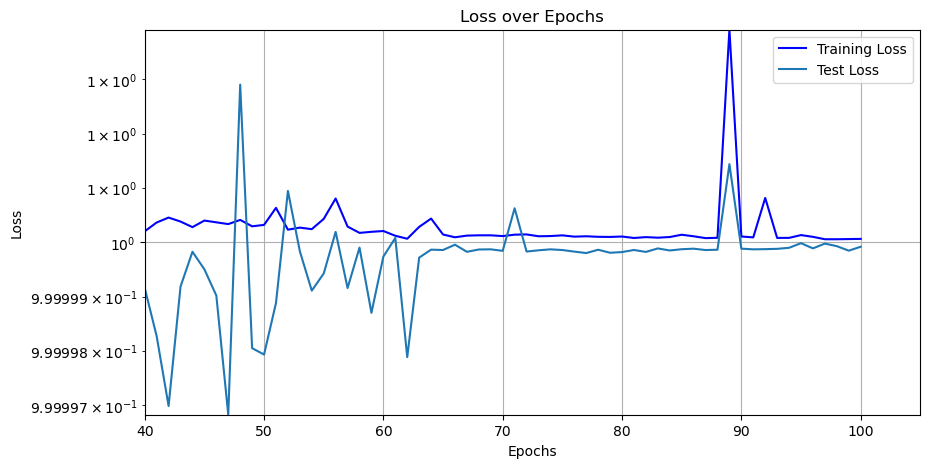

In [89]:
plot_losses(train_losses=train_losses2, test_losses=test_losses2, xmin=40)

Something is not right about how I am training on the residuals